In [953]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
from IPython.display import Image, HTML

In [954]:
# -------------------------------------------------
# Matplotlib settings for thicker lines & bigger fonts
# -------------------------------------------------
plt.rcParams.update({
    'font.size': 18,          # Default text size
    'axes.labelsize': 18,     # Axis label size
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2,     # Thicker lines by default
    'lines.markersize': 9,
    'axes.linewidth': 2,
    'xtick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.size': 10,
    'ytick.major.width': 2,
    'xtick.minor.size': 5,
    'xtick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.minor.width': 1
})


# Heat Capacity | Superfluid Helium 

Before we can do any analysis, we need to be able to convert between pressure and temperature for Helium 4. 

For this, given measured datapoints from the He4 scale of 1958, we will fit a polynomial and use this as our temperature scale.

$$
T = a_0 + a_1 \log(P) + a_2 \log^2(P) + \dots
$$

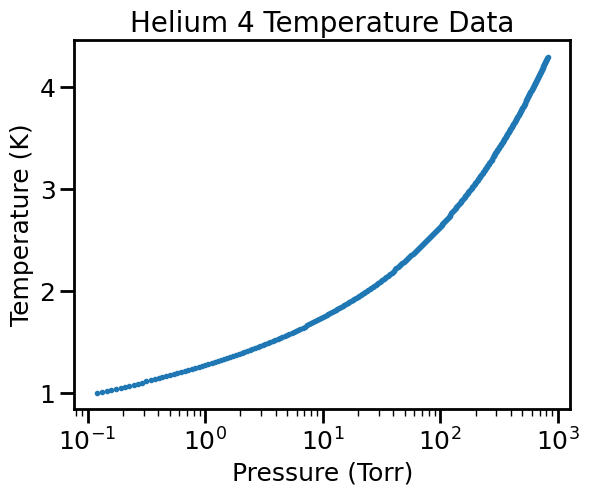

In [955]:
# we load the data from the Wiki (obtained from the 1958 scale)
temperature_scale = np.loadtxt("../Data/helium_temperature_scale.txt")
equilibrium_vapor_pressures = temperature_scale[:,0]/1000 # we divide by 100 to convert to Tors
equilibrium_temperatures = temperature_scale[:,1]


plt.plot(equilibrium_vapor_pressures, equilibrium_temperatures, 'o', markersize=3)

plt.xscale('log')

plt.xlabel('Pressure (Torr)')
plt.ylabel('Temperature (K)')
plt.title('Helium 4 Temperature Data')
plt.show()


In [956]:
# we know fit a polynomial like explained above

lnP = np.log(equilibrium_vapor_pressures)
T   = equilibrium_temperatures

degree =5
coeffs = np.polyfit(lnP, T, deg=degree)

# we define a function with the parameters of our model
def helium_T_of_P(P):
    """
    Returns the temperature (K) given a vapor pressure P (Pa),
    based on a polynomial fit in ln(P).
    """
    return np.polyval(coeffs, np.log(P))


# we evaluate the model by computing the RMS error
fit_values = helium_T_of_P(equilibrium_vapor_pressures)
errors = fit_values - T
rms_error = np.sqrt(np.mean(errors**2))

print(f"RMS error: {rms_error:.6f} K")

RMS error: 0.001111 K


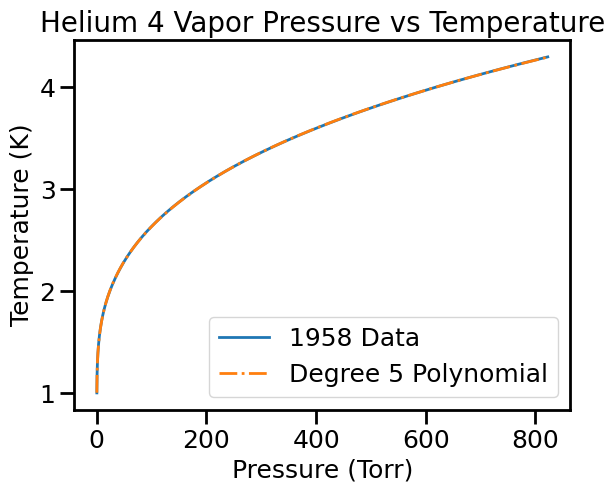

In [957]:
# compare the model to the data for a visual check
plt.figure()
plt.plot(equilibrium_vapor_pressures, equilibrium_temperatures, '-', label='1958 Data')

plt.plot(equilibrium_vapor_pressures, fit_values, '-.', label='Degree 5 Polynomial')

plt.xlabel('Pressure (Torr)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Helium 4 Vapor Pressure vs Temperature')
plt.show()

Beautiful. Now we can proceed with the analysis

## Calibrating the Germanium thermometer

In [958]:
ge_df = pd.read_excel('../Data/HeatCapacity/compiledHeatCapacityData.xlsx', sheet_name='Sheet2')
print(ge_df.head())

   Pressure (mTorr)  Voltage (mV)
0             775.0         0.629
1             770.0         0.632
2             760.0         0.636
3             750.0         0.640
4             745.0         0.645


In [959]:
ge_temperatures = [helium_T_of_P(p) for p in ge_df['Pressure (mTorr)']]
ge_voltages = ge_df['Voltage (mV)']

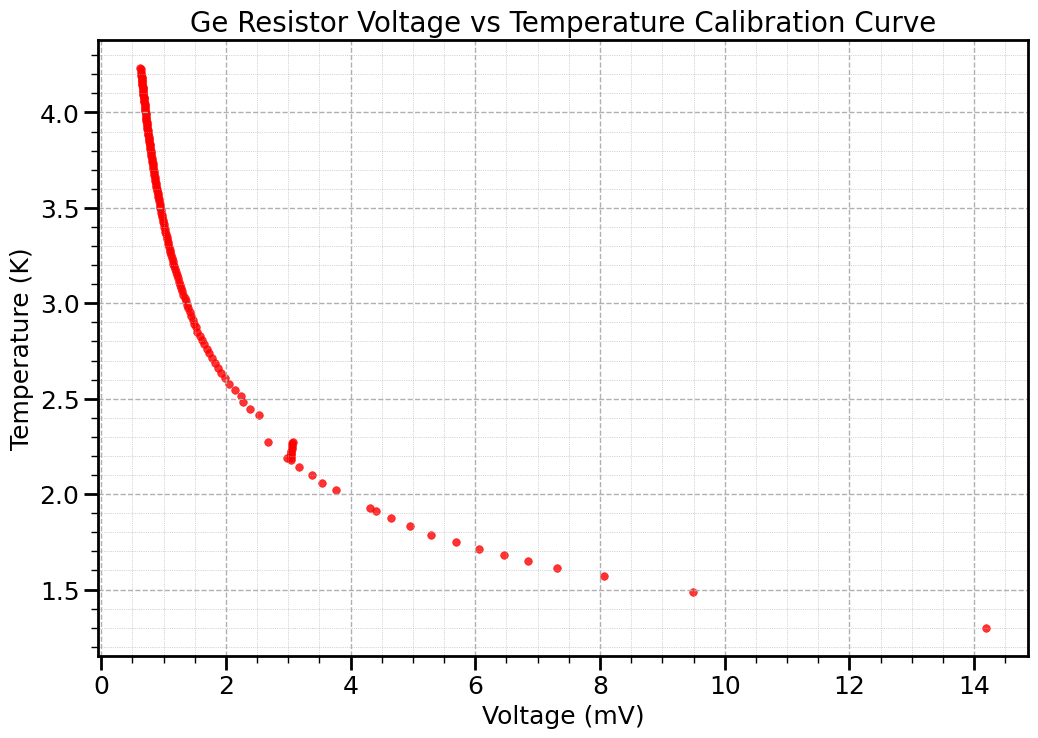

In [960]:

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(ge_voltages,
           ge_temperatures,
           s=30, color='red', linewidths=0.5, alpha=0.8)


ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Voltage (mV)')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('Ge Resistor Voltage vs Temperature Calibration Curve')

ax.grid(True, which='major', linestyle='--', linewidth=1)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)

ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()


Notice that this curve resembles an exponential. According to the Germanium Thermometer Calibration paper (Martin, 1975), the Ge resistance vs temperature relationship in the $2-20 K$ range is approximately given by

$$
\log(R) = A - B \log(T)
$$

Where $A, B$ are constants. Since we are running this experiment at roughly constant current, by Ohm's law we can relate $R = \frac{V}{I}$ and thus we expect a similar functional form

$$
\log(V) = A - B \log(T)
$$

We want to use the measured $V$ as a probe to estimate the temperature, so we can invert the relationship to find

$$
\log(V) = A' + B' \log(T)
$$

Where $A', B'$ are constants.

We plot this

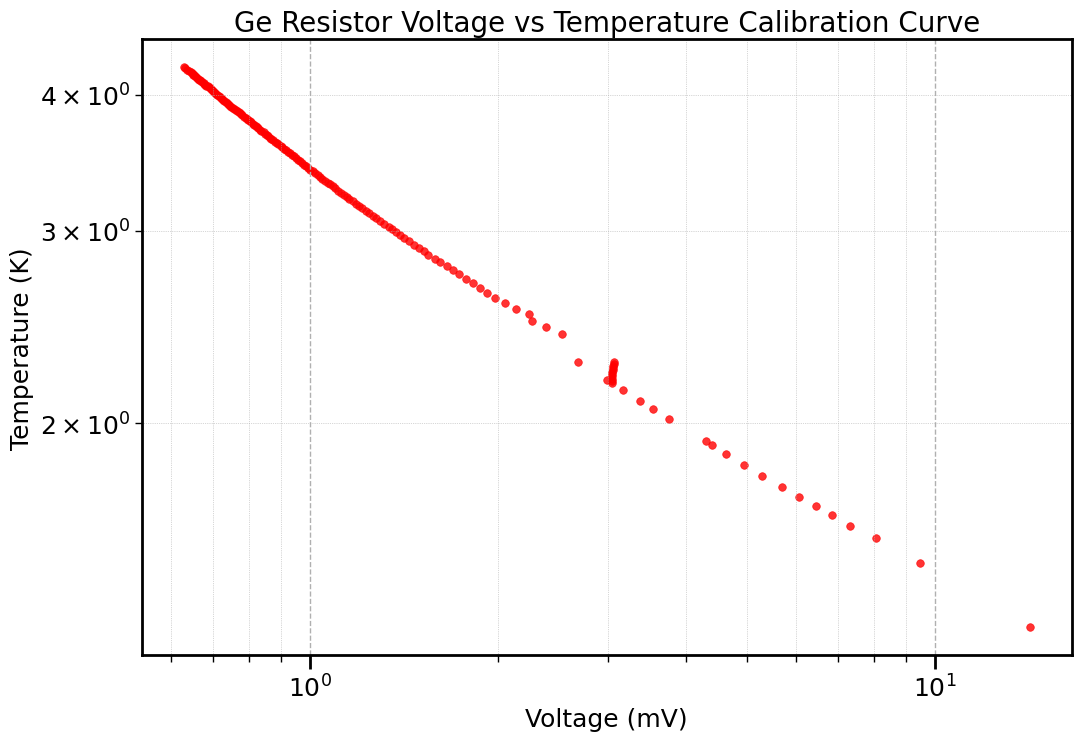

In [961]:

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(ge_voltages,
           ge_temperatures,
           s=30, color='red', linewidths=0.5, alpha=0.8)


ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Voltage (mV)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Ge Resistor Voltage vs Temperature Calibration Curve')

ax.grid(True, which='major', linestyle='--', linewidth=1)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)


plt.show()

This seems to follow well the expected linear relationship from the paper! We confirm by fitting a linear curve


In [962]:
lnT = np.log(ge_temperatures)
lnV  = np.log(ge_voltages)

degree = 1
ge_coeffs = np.polyfit(lnV, lnT , deg=degree)

# we define a function with the parameters of our model
def germanium_T_of_V(V):
    """
    Return T (K) from a power-law fit:
    ln(T) = c0 + c1 * ln(V).
    """
    lnT_fit = np.polyval(ge_coeffs, np.log(V)) 
    return np.exp(lnT_fit)  # Convert ln(T) back to T


# we evaluate the model by computing the RMS error
predictions = germanium_T_of_V(ge_voltages)

errors = predictions - ge_temperatures
rms_error = np.sqrt(np.mean(errors**2))

print(f'Fit coefficients: {ge_coeffs}')
print(f"RMS error: {rms_error:.6f} K")

Fit coefficients: [-0.396114    1.23941008]
RMS error: 0.043228 K


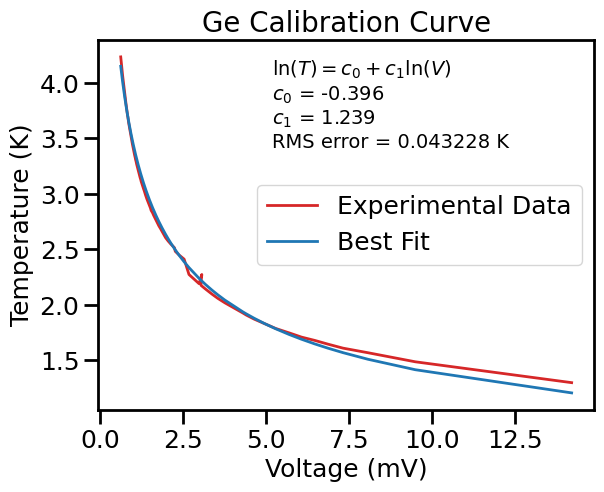

In [963]:
plt.plot(ge_voltages, ge_temperatures, color='tab:red', label = 'Experimental Data')
plt.plot(ge_voltages, predictions, color='tab:blue', label = 'Best Fit')
# plt.loglog()

plt.title('Ge Calibration Curve')
plt.xlabel('Voltage (mV)')
plt.ylabel('Temperature (K)')

# Build a text string displaying the equation and fit parameters
equation_text = r"$\ln(T) = c_0 + c_1 \ln(V)$"  # The equation in LaTeX form
params_text = (rf"$c_0$ = {ge_coeffs[0]:.3f}" + "\n"
               rf"$c_1$ = {ge_coeffs[1]:.3f}" + "\n"
               f"RMS error = {rms_error:.6f} K")

text_string = equation_text + "\n" + params_text

# Place the text box within the axes
plt.text(
    0.35, 0.95, text_string,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0)
)

plt.legend()
plt.show()


We obtain a good fit! 

We are now ready to move on with the experimental data collection

## Heat Capacity of Copper (Cu) Cell


First, we find the heat capacity of the $Cu$ cell. To do this, we first performed the calorimetry experiment with the empty copper cell with the following characteristics:

$$
m_{cell} = 14.8 g
$$

$$
V_{cell} = 1.4 cm^3 \quad V_{cell + tubing} =  7.4 cm^3
$$


And recall that the power dissipated by a resister is given by

$$
P = I  V = \frac{V^2}{R} = I^2 R
$$

So the heat introduced per pulse is given by 

$$
Q = P  \Delta t
$$

In [964]:
# First, we load the experimental data
empty_cell_data = np.loadtxt('../Data/HeatCapacity/helium heat capacity/runs/emptycell_run3')

empty_cell_data

array([[8.28802e-01, 3.99990e+01],
       [8.29183e-01, 4.00990e+01],
       [8.29045e-01, 4.01990e+01],
       ...,
       [1.22051e-01, 6.76999e+02],
       [1.22025e-01, 6.77099e+02],
       [1.22065e-01, 6.77199e+02]], shape=(6373, 2))

In [965]:
ge_voltages = empty_cell_data[:,0]* 10 #we multiply by 10 to convert to mV
times = empty_cell_data[:,1]

In [966]:
# x_min = 40
# x_max = 100

# mask = (times >= x_min) & (times <= x_max)

# primary_color = 'darkslateblue'
# secondary_color = 'goldenrod'

# # Create the main figure and axis
# fig, ax1 = plt.subplots()

# # Plot the original ge_voltages on the primary y-axis
# ax1.plot(times[mask], ge_voltages[mask], color=primary_color, lw=2, label='Ge Voltage')
# ax1.set_xlabel("Time (A. U.)", fontsize=14)
# ax1.set_ylabel("Ge Voltage (mV)", color=primary_color, fontsize=14)
# ax1.tick_params(axis='y', labelcolor=primary_color, labelsize=12)

# # Enable minor ticks for a finer grid
# ax1.minorticks_on()

# # Add gridlines for both major and minor ticks
# ax1.grid(which='major', linestyle='-', linewidth=0.7, color='gray', alpha=0.7)
# ax1.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# # Create a twin axis sharing the same x-axis and plot the transformed data
# ax2 = ax1.twinx()
# ax2.plot(times[mask], germanium_T_of_V(ge_voltages[mask]), color=secondary_color, lw=2, label='Transformed Voltage')
# ax2.set_ylabel("Temperature (K)", color=secondary_color, fontsize=14)
# ax2.tick_params(axis='y', labelcolor=secondary_color, labelsize=12)

# plt.title("Empty Cu Cell Calorimetry Data", fontsize=16)
# plt.show()


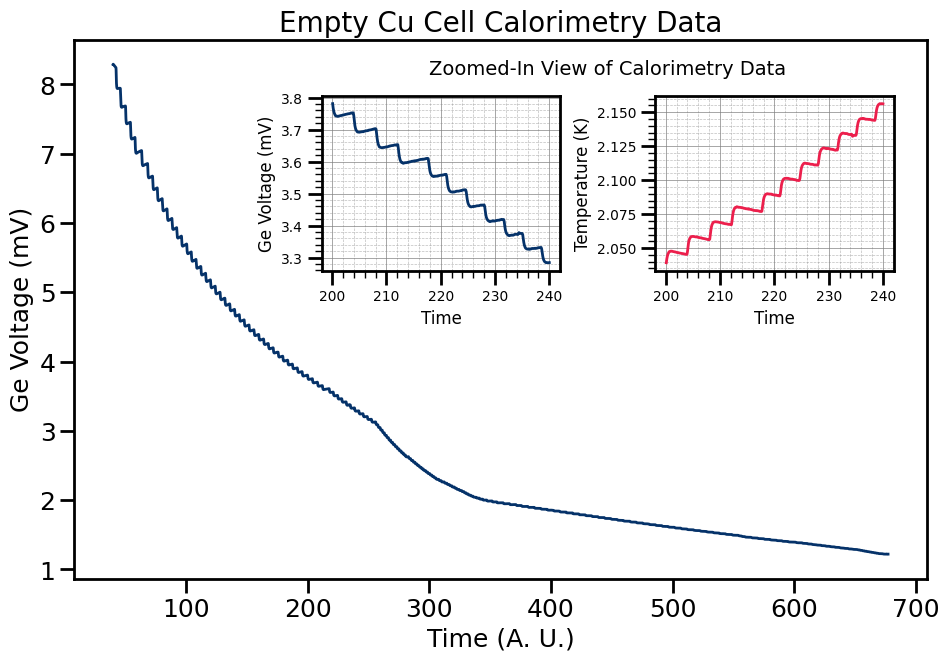

In [967]:
x_min = 200
x_max = 240
mask = (times >= x_min) & (times <= x_max)

color_blue = '#053269'
color_red = '#EC1F4C' #'#FF9B71'
# 1) Create a larger figure and the main axis
fig, ax_main = plt.subplots(figsize=(11, 7))  # Increase figure size
ax_main.plot(times, ge_voltages, color=color_blue, label='Ge Voltage')
ax_main.set_xlabel("Time (A. U.)",)
ax_main.set_ylabel("Ge Voltage (mV)")
ax_main.tick_params(axis='y',)
ax_main.tick_params(axis='x',)
ax_main.set_title("Empty Cu Cell Calorimetry Data",)

# ax_main.grid(which='major', linestyle='-', linewidth=0.7, color='gray', alpha=0.7)

# 2) Create a small GridSpec region for the inset mosaic in the top-right
#    Adjust these values to reposition or resize the inset
gs_inset = fig.add_gridspec(
    nrows=1, ncols=2,      # 1 row, 2 columns (side-by-side)
    left=0.35, bottom=0.55, # position the inset
    right=0.87, top=0.8,  # size of the inset region
    wspace=0.4             # horizontal spacing between the two inset plots
)

# 3) Define two subplots within the inset
ax_inset_left = fig.add_subplot(gs_inset[0, 0])
ax_inset_right = fig.add_subplot(gs_inset[0, 1])

# 4) Left inset: masked data
ax_inset_left.plot(times[mask], ge_voltages[mask], color=color_blue)
# ax_inset_left.set_title("Ge Voltage", fontsize=12)
ax_inset_left.set_xlabel("Time", fontsize=12)
ax_inset_left.set_ylabel("Ge Voltage (mV)", fontsize=12)
ax_inset_left.tick_params(axis='both', labelsize=10)

# Enable minor ticks and add gridlines for both major and minor ticks on the left inset
ax_inset_left.minorticks_on()
ax_inset_left.grid(which='major', linestyle='-', linewidth=0.7, color='gray', alpha=0.7)
ax_inset_left.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)


# 5) Right inset: transformed (masked) data
ax_inset_right.plot(times[mask], germanium_T_of_V(ge_voltages[mask]), color=color_red)
# ax_inset_right.set_title("Temperature", fontsize=12)
ax_inset_right.set_xlabel("Time", fontsize=12)
ax_inset_right.set_ylabel("Temperature (K)", fontsize=12)
ax_inset_right.tick_params(axis='both', labelsize=10)

# Enable minor ticks and add gridlines for both major and minor ticks on the right inset
ax_inset_right.minorticks_on()
ax_inset_right.grid(which='major', linestyle='-', linewidth=0.7, color='gray', alpha=0.7)
ax_inset_right.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

fig.text(0.61, 0.83, "Zoomed-In View of Calorimetry Data", ha="center", fontsize=14)


plt.savefig('../Figures/HeatCapacity/empty_raw_data.png', dpi=300)
plt.show()



Every dip in the voltage curve corresponds to the applied heat pulse from the resistor.

To analyze this curve, we must identify each of the dips and isolate the temperature readings in between dips. We will then convert the voltage data to temperature, and using the following equation estimate the value of $C_{cell}$ from the following equation

$$
0 = -Q_{resistor} + Q_{cell} = - \frac{V^2}{R}\Delta t + m C_{cell} \Delta T
$$

$$
\implies C_{cell} = \frac{V^2 \Delta t}{R m \Delta T}
$$

for each interval in between heat pulses

We start by calculating and plotting the derivatives.

After playing around with it, we realize that the value of the derivative keeps decreasing, and the `peak_finder` function has a hard time findind all the peaks. To get around this, we will analyze the data in batcher, so the peaks in each batch are roughly of the same size and thus are easier to correctly label without accidentally counting erroneous peaks.


Batches: 


| $t_{min}$ | $t_{max}$ |
|---------|---------|
| 0       | 300     |
| 300     | 600     |
| 600     | 640     |
| 640     | 665     |



In [968]:
def plot_voltage_and_derivatives(times, voltages, derivatives, peaks = None, x_lim = None, y_lim_1 = None, y_lim_2 = None, title = None, filename = None):

    fig, ax1 = plt.subplots(figsize=(11, 7))

    ax1.plot(times, voltages, color='blue', label='Ge Voltage')
    ax1.set_xlabel("Time (A. U.)")
    ax1.set_ylabel("Ge Voltage (mV)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a twin y-axis and plot the derivative data
    ax2 = ax1.twinx()
    ax2.plot(times[:-1], derivatives, color='red', label='Derivative')
    ax2.set_ylabel("dV/dt", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    if peaks is not None:
        ax2.plot(times[:-1][peaks], derivatives[peaks], 'o', color='black')

    if x_lim is not None:
        plt.xlim(x_lim[0], x_lim[1])

    if y_lim_1 is not None:
        ax1.set_ylim(y_lim_1[0], y_lim_1[1])

    if y_lim_2 is not None:
        ax2.set_ylim(y_lim_2[0], y_lim_2[1])


    if title is not None:
        plt.title(title)

    

    plt.show()



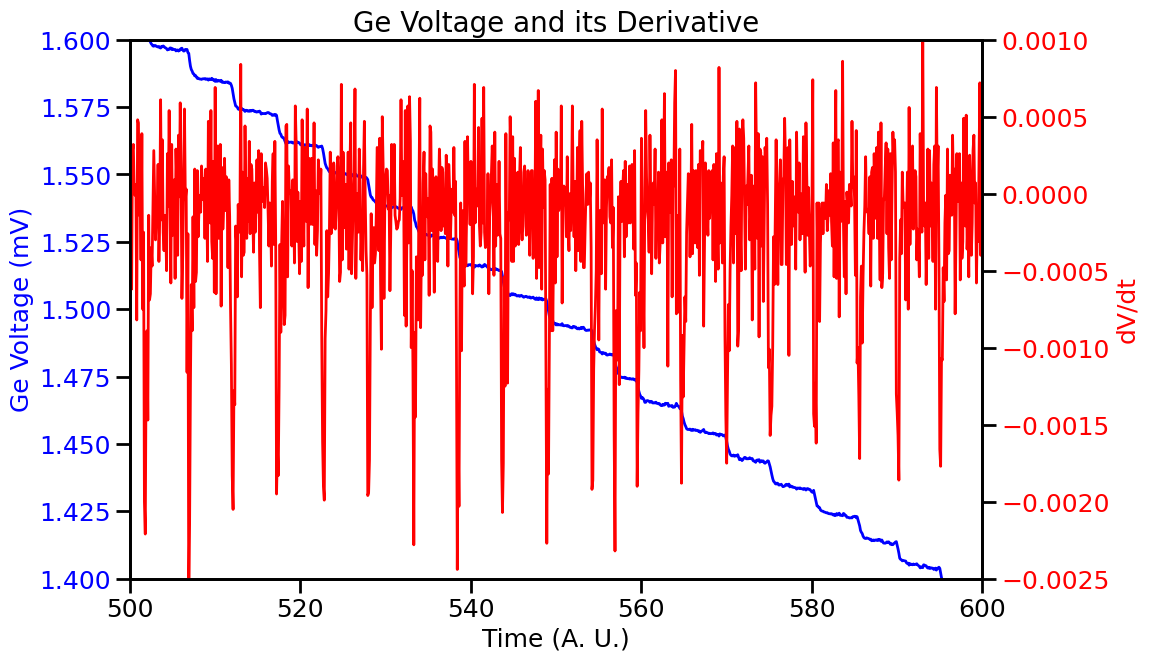

In [969]:
derivatives = np.diff(ge_voltages)

plot_voltage_and_derivatives(times
                             ,ge_voltages, 
                             derivatives, 
                             title = "Ge Voltage and its Derivative", 
                             x_lim=(500, 600),
                             y_lim_1=(1.4,1.6),
                             y_lim_2=(-0.0025, 0.001))


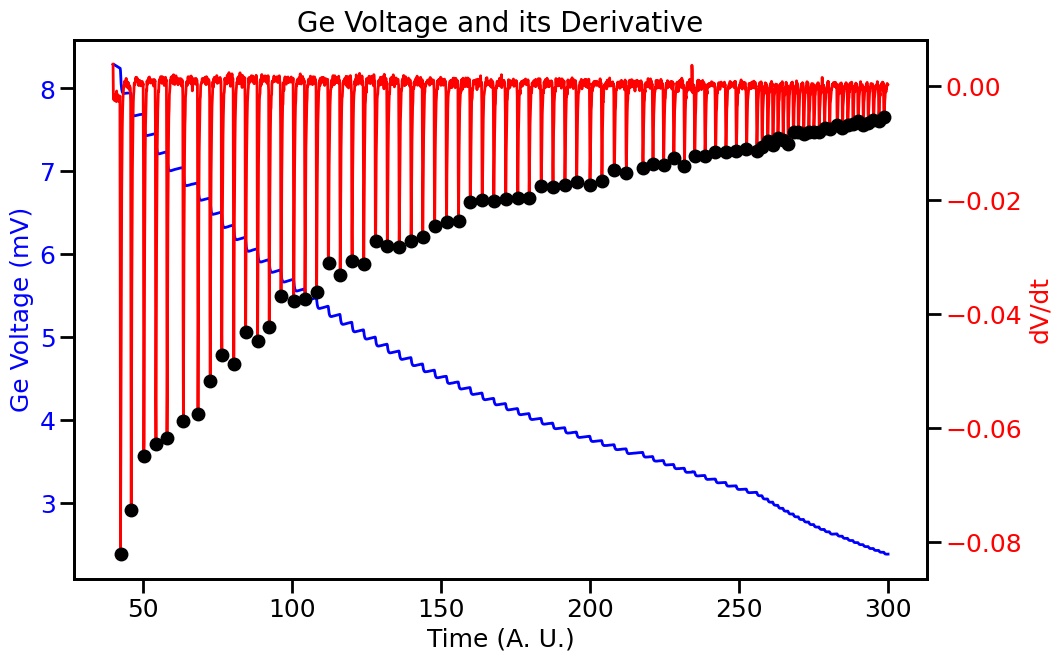

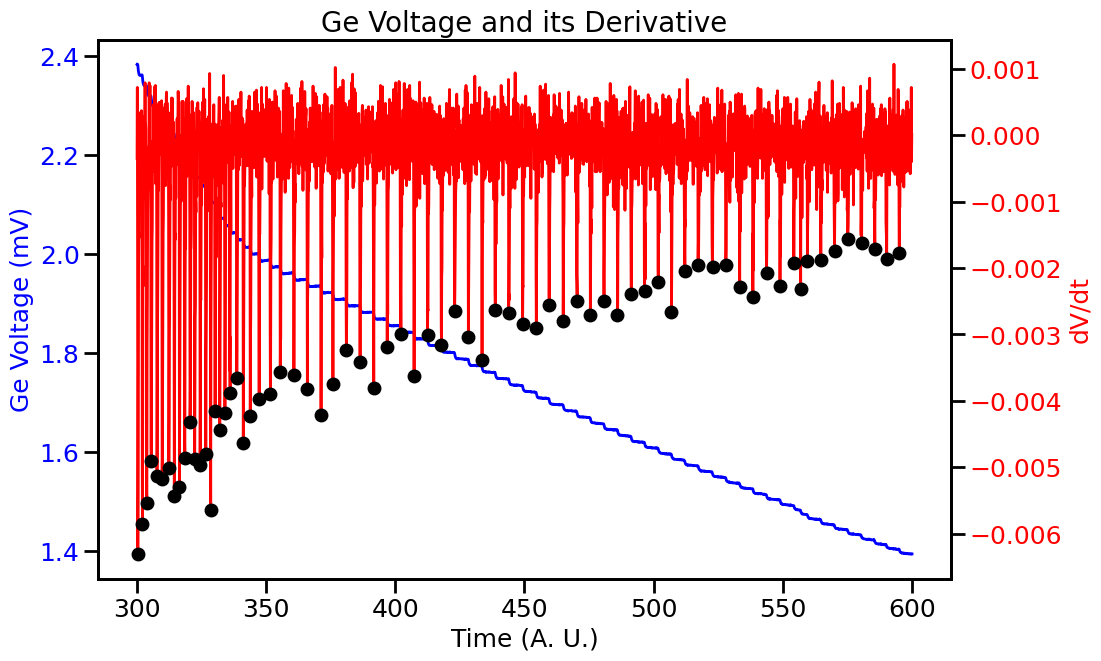

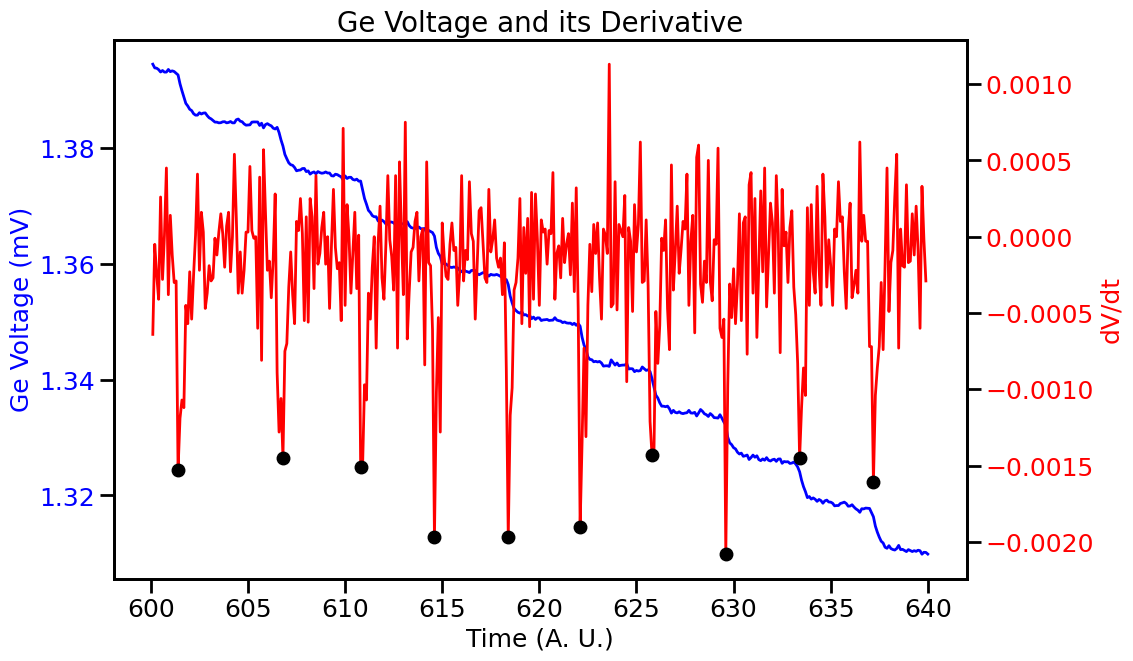

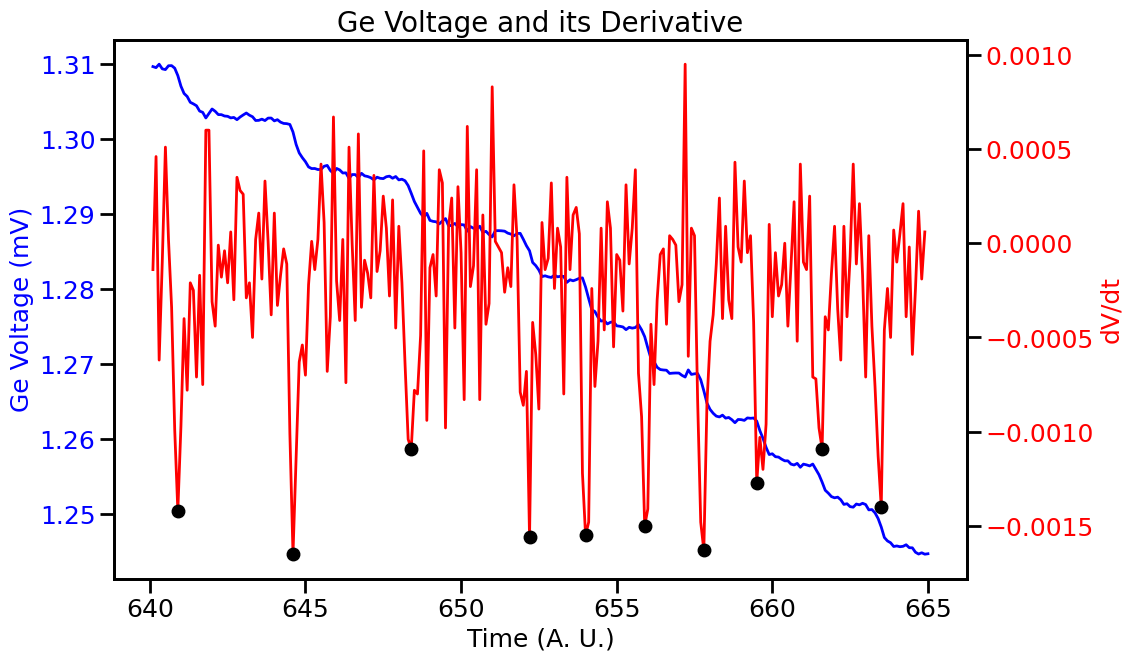

In [970]:
# we divide the data in four batches. For each batch, we find the peaks and find their x (time) coordingates

mask_1 = (times > 0) & (times <= 300)

derivatives = np.diff(ge_voltages[mask_1])
ge_peaks_ind_1 , _ = find_peaks(-derivatives, prominence=0.005, distance=10)

# Here we find the x (time) coordinate
# we first apply the mask (so we are in the correct batch), 
# then make sure to match the dimensions (hence we remove last point), 
# and then we apply the mask again to collect the x coordinate of the peaks in this batch (time interval)
ge_peaks_1 = times[mask_1][:-1][ge_peaks_ind_1]

plot_voltage_and_derivatives(times[mask_1],
                             ge_voltages[mask_1],
                             derivatives, 
                             ge_peaks_ind_1,
                             title = "Ge Voltage and its Derivative",)


mask_2 = (times > 300 ) & (times <= 600)

derivatives = np.diff(ge_voltages[mask_2])
ge_peaks_ind_2 , _ = find_peaks(-derivatives, prominence=0.002)

# we first apply the mask, then make sure to match the dimensions, and then apply the mask again
ge_peaks_2 = times[mask_2][:-1][ge_peaks_ind_2]

plot_voltage_and_derivatives(times[mask_2],
                             ge_voltages[mask_2],
                             derivatives, 
                             ge_peaks_ind_2,
                             title = "Ge Voltage and its Derivative")


mask_3 = (times > 600 ) & (times <= 640)

derivatives = np.diff(ge_voltages[mask_3])
ge_peaks_ind_3 , _ = find_peaks(-derivatives, prominence=0.0015, distance = 30)

# we first apply the mask, then make sure to match the dimensions, and then apply the mask again
ge_peaks_3 = times[mask_3][:-1][ge_peaks_ind_3]

plot_voltage_and_derivatives(times[mask_3],
                             ge_voltages[mask_3],
                             derivatives, 
                             ge_peaks_ind_3,
                             title = "Ge Voltage and its Derivative")

mask_4 = (times > 640 ) & (times <= 665)

derivatives = np.diff(ge_voltages[mask_4])
ge_peaks_ind_4 , _ = find_peaks(-derivatives, prominence=0.0015, distance = 15)

# we first apply the mask, then make sure to match the dimensions, and then apply the mask again
ge_peaks_4 = times[mask_4][:-1][ge_peaks_ind_4]

plot_voltage_and_derivatives(times[mask_4],
                             ge_voltages[mask_4],
                             derivatives, 
                             ge_peaks_ind_4,
                             title = "Ge Voltage and its Derivative")



####### NOTE ######

# After careful inspection of the data, the last few datapoints are too noisy
# Thus, we are ignoring those last few points. It shouldn't have too big of an impact

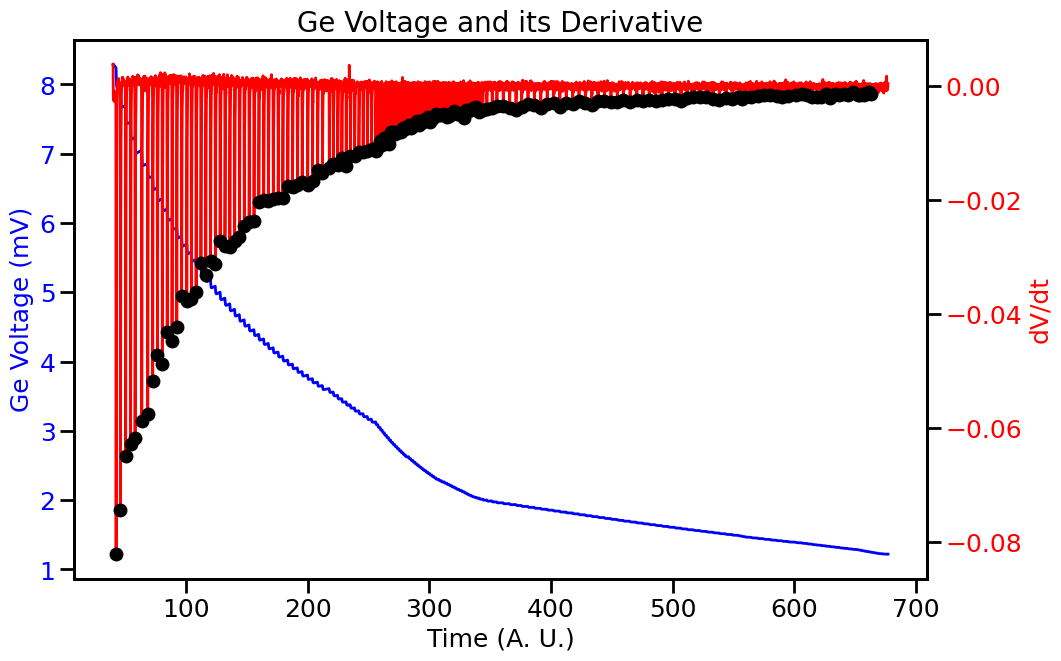

In [971]:
peaks = np.concatenate((ge_peaks_1, ge_peaks_2, ge_peaks_3, ge_peaks_4))
 
peaks_ind = np.where(np.isin(times, peaks))[0]


derivatives = np.diff(ge_voltages)

plot_voltage_and_derivatives(times
                             ,ge_voltages, 
                             derivatives,
                             peaks = peaks_ind, 
                             title = "Ge Voltage and its Derivative",)
                            #  x_lim=(40, 130),
                            #  y_lim_1=(4.5,8.4),
                            #  y_lim_2=(-0.1, 0.001))


Beautiful!

Now we use the peak values to separate our data in intervals between heat pulses

In [972]:
intervals = []

for ii in range(len(peaks_ind)-1):

    intervals.append(ge_voltages[peaks_ind[ii]:peaks_ind[ii+1]])


After each pulse, we observe that the system takes some time to equilibrate. Thus, we must estimate the final temperature using data from the right tail of each interval. 

To do this, we will use the last $20\%$ of the datapoints for each interval.

In [973]:
def get_average_voltage(data, cutoff=0.20):

    length = len(data)

    return np.average(data[-np.floor(length):])


average_voltages = np.array([get_average_voltage(data) for data in intervals])


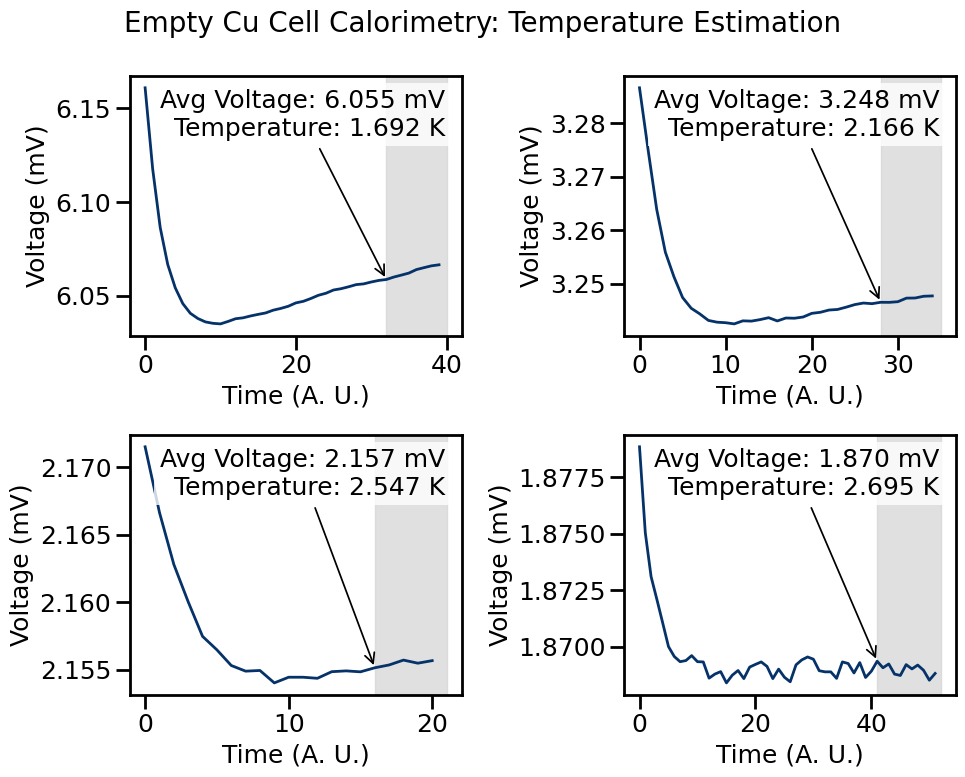

In [974]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axs = axs.flatten()


for i, interval_index in enumerate([10, 50, 90, 110]):

    data = intervals[interval_index]
    average_voltage = average_voltages[interval_index]
    temperature = germanium_T_of_V(average_voltage)

    axs[i].plot(data, color=color_blue)
    axs[i].set_xlabel('Time (A. U.)')
    axs[i].set_ylabel('Voltage (mV)')

        # Calculate the starting index for the last 20% of data
    N = len(data)
    start_idx = int(0.8 * N)
    
    # Shade the last 20% region
    axs[i].axvspan(start_idx, N, color='lightgray', alpha=0.7)
    
     # Annotation text
    annotation_text = (
        f"Avg Voltage: {average_voltage:.3f} mV\n"
        f"Temperature: {temperature:.3f} K"
    )

    # Place the text in the top-right corner of the subplot
    # and draw an arrow pointing to the start of the shaded region
    axs[i].annotate(
        annotation_text,
        xy=(start_idx, data[start_idx]),       # arrow tip at start of shaded region
        xycoords='data',                       # interpret (start_idx, data[start_idx]) in data coordinates
        xytext=(0.95, 0.95),                   # place the text box in top-right of the subplot
        textcoords='axes fraction',            # interpret (0.95, 0.95) in axes fraction
        arrowprops=dict(arrowstyle='->', color='black', lw=1.25),
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
        ha='right', va='top'
    )


fig.suptitle('Empty Cu Cell Calorimetry: Temperature Estimation', fontsize=20)


plt.tight_layout()

plt.savefig('../Figures/HeatCapacity/empty_temperature_estimation_mosaic.png', dpi=300)

plt.show()

Nice! Now, we need to estimate the power that we introduced into the resistor. To do so, we will load the oscilloscope data and measure the pulse amplitude and duration.

Below is a picture of the scope data we collected

In [975]:
filename = "../Data/HeatCapacity/helium heat capacity/pulse data/tek0016.png"
html_str = f'<div style="text-align: center;"><img src="{filename}" width="700" height="500"></div>'
display(HTML(html_str))


In [976]:
# Loading scope data

filename = "../Data/HeatCapacity/helium heat capacity/pulse data/tek0016.csv"

# Step 1: Figure out how many lines to skip to reach the data
with open(filename, 'r') as f:
    lines = f.readlines()

# Find the header row (the row that starts with "TIME,CH1,...")
header_line = None
for idx, line in enumerate(lines):
    if line.strip().startswith("TIME,CH1,CH2,CH3"): # this line is used to define where the data starts
        header_line = idx
        break

if header_line is None:
    raise ValueError(f"No data header found in {filename}")

# Step 2: Read the file into a DataFrame, starting at the detected header
oscilloscope_df = pd.read_csv(filename, skiprows=header_line, delimiter=",")


oscilloscope_df.head()


,TIME,CH1,CH2,CH3
0,-0.01960,0.00,-0.04,-0.1
1,-0.01958,-0.08,0.04,0.1
2,-0.01956,-0.08,-0.04,0.1
3,-0.01954,-0.08,-0.04,0.1
4,-0.01952,-0.08,-0.04,0.1


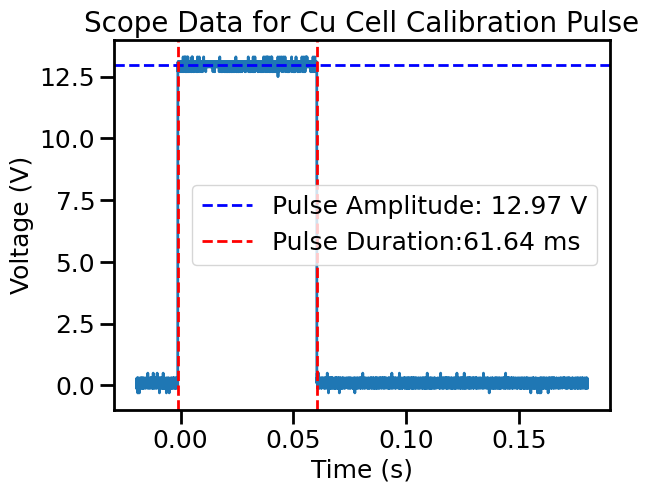

In [977]:
scope_time = oscilloscope_df['TIME']
scope_voltage = oscilloscope_df['CH3']

# we find the start and end values of the pulse simply by defining a threshold
#  and recording the first and last indices above this threshold

threshold = 0.5 * (scope_voltage.max() + scope_voltage.min())  # or pick a specific voltage

pulse_amplitude = np.average(scope_voltage[scope_voltage>threshold])

rising_indices = np.where(scope_voltage > threshold)[0]

start_idx = rising_indices[0]  
end_idx = rising_indices[-1]

pulse_duration = scope_time[end_idx] - scope_time[start_idx]


plt.plot(scope_time, scope_voltage)

plt.axhline(y=pulse_amplitude, color='blue', linestyle='--', label=f'Pulse Amplitude: {pulse_amplitude:.2f} V')

plt.axvline(x=scope_time[start_idx], color='red', linestyle='--')
plt.axvline(x=scope_time[end_idx], color='red', linestyle='--', label= f'Pulse Duration:{pulse_duration*1000:.2f} ms')

plt.title('Scope Data for Cu Cell Calibration Pulse')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

The heater is a $1.4 K\Omega$ resistor. Therefore, it follows that the heat introuduced by the resistor is

$$
Q = \frac{V^2 \Delta t}{R}
$$

In [978]:
heater_resistance = 1.4e3

heat_in = pulse_amplitude**2 * pulse_duration / heater_resistance

print(f'Q = {heat_in} J')

Q = 0.007400818357970787 J


We can finally calculate the specific heat as a function of temperature. Recall that

$$
C_{cell} = \frac{V^2 \Delta t}{R m \Delta T}
$$

In [986]:
def get_copper_heat_capacity(V, R, dt, dT, m=14.8):

    return (
        (V**2 * dt) / (R * m * dT)
    )

In [994]:
average_temperatures = germanium_T_of_V(average_voltages)


temperature_deltas = np.diff(average_temperatures)

heat_capacities = []

for i in range(len(average_temperatures[:-1])):
    heat_capacities.append(get_copper_heat_capacity(V = pulse_amplitude, 
                                                    R = heater_resistance,
                                                    dt = pulse_duration,
                                                    dT = temperature_deltas[i]))
    


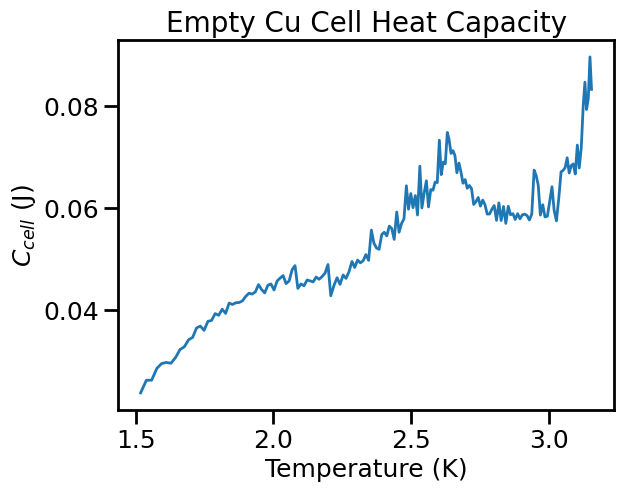

In [997]:
plt.plot(average_temperatures[:-1], heat_capacities)


plt.xlabel('Temperature (K)')
plt.ylabel(r'$C_{cell}$ (J)')
plt.title('Empty Cu Cell Heat Capacity')

plt.show()